In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import print_function
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time

from pydrake.solvers.mathematicalprogram import MathematicalProgram, Solve
from pydrake.solvers.ipopt import IpoptSolver

In [6]:
mp = MathematicalProgram()
xy = mp.NewContinuousVariables(2, "xy")

#def constraint(xy):
#    return np.array([xy[0]*xy[0] + 2.0*xy[1]*xy[1]])
#constraint_bounds = (np.array([0.]), np.array([1.]))
#mp.AddConstraint(constraint, constraint_bounds[0], constraint_bounds[1], xy)

def constraint(xy):
    theta = 1.0
    return np.array([[np.cos(theta), -np.sin(theta)],
                     [np.sin(theta), np.cos(theta)]]).dot(
        np.array([xy[0], xy[1]]))
constraint_bounds = (np.array([-0.5, -0.5]), np.array([0.5, 0.5]))
mp.AddConstraint(constraint, constraint_bounds[0], constraint_bounds[1], xy)

def cost(xy):
    return xy[0]*1.0 + xy[1]*1.0

mp.AddCost(cost, xy)
#solver = IpoptSolver()
#result = solver.Solve(mp, None, None)
result = Solve(mp)
xystar = result.GetSolution()
print("Successful: ", result.is_success())
print("Solver: ", result.get_solver_id().name())
print("xystar: ", xystar)

Successful:  True
Solver:  SNOPT/f2c
xystar:  [-0.15058434 -0.69088665]


In [7]:
# Demo of pulling costs / constraints from MathematicalProgram
# and evaluating them / getting gradients.
from pydrake.forwarddiff import gradient, jacobian

costs = mp.GetAllCosts()
total_cost_gradient = np.zeros(xystar.shape)
for cost in costs:
    print("Cost: ", cost)
    print("Eval at xystar: ", cost.evaluator().Eval(xystar))
    grad = gradient(cost.evaluator().Eval, xystar)
    print("Gradient at xystar: ", grad)
    total_cost_gradient += grad
constraints = mp.GetAllConstraints()
total_constraint_gradient = np.zeros(xystar.shape)
for constraint in constraints:
    print("Constraint: ", constraint)
    val = constraint.evaluator().Eval(xystar)
    print("Eval at xystar: ", val)
    jac = jacobian(constraint.evaluator().Eval, xystar)
    print("Gradient at xystar: ", jac)
    total_constraint_gradient -= (val <= constraint_bounds[0] + 1E-6).dot(jac)
    total_constraint_gradient += (val >= constraint_bounds[1] - 1E-6).dot(jac)

if np.any(total_cost_gradient):
    total_cost_gradient /= np.linalg.norm(total_cost_gradient)
if np.any(total_constraint_gradient):
    total_constraint_gradient /= np.linalg.norm(total_constraint_gradient)
print("Total cost grad dir: ", total_cost_gradient)
print("Total constraint grad dir: ", total_constraint_gradient)

Cost:  <pydrake.solvers.mathematicalprogram.Binding_Cost object at 0x7f4e53967030>
Eval at xystar:  [-0.84147098]
Gradient at xystar:  [1. 1.]
Constraint:  <pydrake.solvers.mathematicalprogram.Binding_Constraint object at 0x7f4e53967bf0>
Eval at xystar:  [ 0.5 -0.5]
Gradient at xystar:  [[ 0.54030231 -0.84147098]
 [ 0.84147098  0.54030231]]
Total cost grad dir:  [0.70710678 0.70710678]
Total constraint grad dir:  [-0.21295842 -0.97706126]


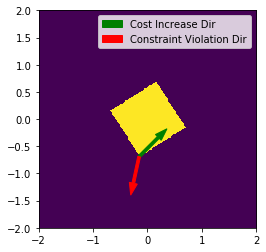

In [8]:
# Draw feasible region
x_bounds = [-2., 2.]
y_bounds = [-2., 2.]
n_pts = [200, 300]
X, Y = np.meshgrid(np.linspace(x_bounds[0], x_bounds[1], n_pts[0]),
                   np.linspace(y_bounds[0], y_bounds[1], n_pts[1]),
                   indexing="ij")

vals = np.ones(n_pts)
for constraint in mp.GetAllConstraints():
    for i in range(n_pts[0]):
        for j in range(n_pts[1]):
            vals_here = constraint.evaluator().Eval(np.array([X[i, j], Y[i, j]]))
            vals[i, j] = (
                np.all(vals_here >= constraint.evaluator().lower_bound()) and
                np.all(vals_here <= constraint.evaluator().upper_bound())
            )
    

plt.imshow(vals, extent=x_bounds+y_bounds)
arrow_cost = plt.arrow(
    xystar[0], xystar[1],
    total_cost_gradient[0]/2., total_cost_gradient[1]/2.,
    width=0.05, color="g")
arrow_constraint = plt.arrow(
    xystar[0], xystar[1],
    total_constraint_gradient[0]/2., total_constraint_gradient[1]/2.,
    width=0.05, color="r")
plt.legend([arrow_cost, arrow_constraint, ], ["Cost Increase Dir", "Constraint Violation Dir"]);